# Librerías

In [301]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score, 
    confusion_matrix, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score, 
    log_loss, roc_curve
)
from scipy.stats import bootstrap

# Funciones auxiliares

In [302]:
# Funciones auxiliares

def preprocess_dataset(dataset, missing_threshold=0.3):
    """
    Limpia y preprocesa el dataset eliminando valores nulos y duplicados.
    Además, elimina columnas con un porcentaje alto de valores faltantes.
    
    Parameters:
    - dataset: pd.DataFrame, dataset a procesar.
    - missing_threshold: float, porcentaje máximo de valores faltantes permitido (entre 0 y 1).
    
    Returns:
    - dataset: pd.DataFrame, dataset limpio.
    - duplicates_removed: int, número de registros duplicados eliminados.
    - dropped_columns: list, nombres de las columnas eliminadas por exceso de valores faltantes.
    """
    # Eliminar duplicados
    dataset_no_duplicates = dataset.drop_duplicates()
    duplicates_removed = len(dataset) - len(dataset_no_duplicates)
    
    # Identificar columnas con más del umbral de valores faltantes
    missing_percentage = dataset_no_duplicates.isnull().mean()
    columns_to_drop = missing_percentage[missing_percentage > missing_threshold].index.tolist()
    
    # Eliminar columnas con muchos valores faltantes
    dataset_cleaned = dataset_no_duplicates.drop(columns=columns_to_drop)
    
    return dataset_cleaned, duplicates_removed, columns_to_drop


def detect_variable_type(dataset, column):
    """
    Detecta automáticamente el tipo de una variable.
    
    Parameters:
    - dataset: pd.DataFrame, el dataset en el que se encuentra la columna.
    - column: str, nombre de la columna a analizar.
    
    Returns:
    - str, tipo de la variable ("Numérica", "Categórica Binaria", "Categórica No Binaria").
    """
    unique_values = dataset[column].nunique()
    
    if dataset[column].dtype == bool or unique_values == 2:
        return "Categórica Binaria"
    elif pd.api.types.is_numeric_dtype(dataset[column]):
        return "Numérica"
    else:
        return "Categórica No Binaria"
    

def convert_column_type(dataset, column, new_type):
    """
    Convierte el tipo de una columna del dataset según la selección del usuario.
    
    Parameters:
    - dataset: pd.DataFrame, dataset con la columna a convertir.
    - column: str, nombre de la columna a convertir.
    - new_type: str, nuevo tipo de la variable ("Numérica", "Categórica Binaria", "Categórica No Binaria").
    
    Returns:
    - None (la conversión se realiza directamente en el dataset).
    """
    try:
        if new_type == "Numérica":
            dataset[column] = pd.to_numeric(dataset[column], errors='coerce')
        elif new_type == "Categórica Binaria":
            dataset[column] = dataset[column].astype(str).astype("category")
        elif new_type == "Categórica No Binaria":
            dataset[column] = dataset[column].astype(str).astype("category")
    except Exception as e:
        print(f"Error al convertir la columna {column} a {new_type}: {e}")


def remove_suffix(col_name):
    return "_".join(col_name.split("_")[:-1]) if "_" in col_name else col_name


def update_predictor_lists(df, fixed_predictors, candidate_predictors):
    updated_fixed = [col for col in df.columns for prefix in fixed_predictors if col.startswith(prefix)]
    updated_candidates = [col for col in df.columns for prefix in candidate_predictors if col.startswith(prefix)]
    return updated_fixed, updated_candidates


def seleccion_forward(df, variables_fijas, variables_candidatas, objetivo, tipo_modelo='lineal', 
                      missing_data_handling='1', max_predictors=10, nivel_confianza=0.95):
    variables_modelo = list(variables_fijas)
    candidatas_restantes = list(variables_candidatas)
    
    # Inicializar los valores óptimos según el tipo de modelo
    if tipo_modelo == 'lineal':
        mejor_criterio = float('inf')  # Para BIC, menor es mejor
    elif tipo_modelo == 'logistica':
        mejor_criterio = 0  # Para AUC-ROC, mayor es mejor
    else:
        raise ValueError("El tipo_modelo debe ser 'lineal' o 'logistica'.")
    
    while candidatas_restantes and len(variables_modelo) < max_predictors:
        mejor_variable = None
        criterio_actual = None
        
        for variable in candidatas_restantes:
            variables_prueba = variables_modelo + [variable]
            X = df[variables_prueba]

            if missing_data_handling == '1':
                X = X.dropna()

            X = sm.add_constant(X)
            y = df.loc[X.index, objetivo]  # Asegurar que y tenga el mismo índice que X

            try:
                X = X.astype(float)
                y = y.astype(float)
                if tipo_modelo == 'lineal':
                    modelo = sm.OLS(y, X).fit()
                    criterio_actual = modelo.bic  # Se usa BIC para selección
                    p_valores = modelo.pvalues  # Obtener p-valores de todas las variables
                elif tipo_modelo == 'logistica':
                    modelo = sm.Logit(y, X).fit(disp=0)
                    y_pred_prob = modelo.predict(X)
                    criterio_actual = roc_auc_score(y, y_pred_prob)  # Se usa AUC-ROC para selección
                    p_valores = modelo.pvalues  # Obtener p-valores de todas las variables
                
                # Verificar si alguna variable tiene p-valor > 0.05
                variables_no_significativas = p_valores[p_valores > 1- nivel_confianza].index.tolist()
                if 'const' in variables_no_significativas:
                    variables_no_significativas.remove('const')
                
                if not variables_no_significativas:
                    if (tipo_modelo == 'lineal' and criterio_actual < mejor_criterio) or \
                       (tipo_modelo == 'logistica' and criterio_actual > mejor_criterio):
                        mejor_criterio = criterio_actual
                        mejor_variable = variable

            except Exception as e:
                print(f"Error al procesar la variable {variable}: {e}")
                continue

        if mejor_variable:
            print(f"✅ Se agrega la variable: {mejor_variable}")
            variables_modelo.append(mejor_variable)
            candidatas_restantes.remove(mejor_variable)
        else:
            break

    # Filtrar el DataFrame con las mejores variables y eliminar valores nulos
    df_filtrado = df[variables_modelo + [objetivo]].dropna()
    print(f"\n🔍 Variables finales seleccionadas: {variables_modelo}")

    return {'mejores_variables': variables_modelo, 'mejor_criterio': mejor_criterio, 'df_filtrado': df_filtrado}


def filter_dataset(dataset, variable_types, filters):
    """
    Aplica múltiples filtros a un dataset según las condiciones definidas.
    """
    if not filters:
        print("No se han aplicado filtros al dataset.")
        return dataset
    
    original_rows = dataset.shape[0]
    dataset_filtered = dataset.copy()
    
    for selected_var, filter_type, filter_values in filters:
        if selected_var not in dataset_filtered.columns:
            print(f"Variable {selected_var} no encontrada en el dataset.")
            continue
        
        if filter_type == "Igual":
            dataset_filtered = dataset_filtered[dataset_filtered[selected_var] == filter_values]
        elif filter_type == "Mayor o igual":
            dataset_filtered = dataset_filtered[dataset_filtered[selected_var] >= filter_values]
        elif filter_type == "Menor o igual":
            dataset_filtered = dataset_filtered[dataset_filtered[selected_var] <= filter_values]
        elif filter_type == "Mayor":
            dataset_filtered = dataset_filtered[dataset_filtered[selected_var] > filter_values]
        elif filter_type == "Menor":
            dataset_filtered = dataset_filtered[dataset_filtered[selected_var] < filter_values]
        elif filter_type == "Entre" and isinstance(filter_values, (tuple, list)) and len(filter_values) == 2:
            dataset_filtered = dataset_filtered[(dataset_filtered[selected_var] >= filter_values[0]) & (dataset_filtered[selected_var] <= filter_values[1])]
        elif filter_type == "Categorías" and isinstance(filter_values, (list, tuple)):
            dataset_filtered[selected_var] = dataset_filtered[selected_var].astype(str).str.strip().str.lower()
            dataset_filtered = dataset_filtered[dataset_filtered[selected_var].isin([str(val).strip().lower() for val in filter_values])]
        else:
            print(f"Filtro no válido para {selected_var}. No se aplicó el filtro.")
    
    filtered_rows = dataset_filtered.shape[0]
    print("Filtros aplicados:")
    for selected_var, filter_type, filter_values in filters:
        print(f"{selected_var} - {filter_type}: {filter_values}")
    
    print(f"El dataset ha pasado de tener {original_rows} filas a {filtered_rows} filas después de aplicar los filtros.")
    
    return dataset_filtered


def compute_confidence_interval(metric_values, confidence):
    """Calcula el intervalo de confianza para una métrica usando bootstrap."""
    ci_lower, ci_upper = np.percentile(metric_values, [(1 - confidence) / 2 * 100, (1 + confidence) / 2 * 100])
    return ci_lower, ci_upper


def bootstrap_metric(y_test, y_pred, y_pred_proba, metric_func, n_bootstrap=1000):
    """Calcula la distribución bootstrap de una métrica."""
    rng = np.random.default_rng(42)
    metric_values = []
    
    for _ in range(n_bootstrap):
        sample_idx = rng.choice(len(y_test), size=len(y_test), replace=True)
        sampled_y_test = y_test.iloc[sample_idx]
        sampled_y_pred = y_pred[sample_idx]
        sampled_y_pred_proba = y_pred_proba[sample_idx] if y_pred_proba is not None else None

        if sampled_y_pred_proba is not None and metric_func == roc_auc_score:
            metric_values.append(metric_func(sampled_y_test, sampled_y_pred_proba))
        else:
            metric_values.append(metric_func(sampled_y_test, sampled_y_pred))

    return np.array(metric_values)


def evaluate_model(y_test, y_pred, target_type, threshold, confidence, n_bootstrap=1000):
    """Evalúa un modelo de clasificación o regresión con intervalos de confianza bootstrap."""
    n = len(y_test)  # Tamaño del dataset

    if target_type == "Categórica Binaria":
        print("\n📊 Evaluación del modelo de clasificación:")
        
        # Aplicar threshold para convertir probabilidades en clases
        y_pred_class = (y_pred >= threshold).astype(int)

        # Convertir valores booleanos a enteros (True/False → 1/0)
        y_test = y_test.astype(int)

        # Matriz de confusión
        unique_labels = sorted(y_test.unique())
        cm = confusion_matrix(y_test, y_pred_class, labels=unique_labels)

        print(f"\n🔹 Evaluación con Threshold = {threshold:.2f}")
        print("\nMatriz de Confusión:")
        print(pd.DataFrame(cm, columns=[f"Predicción {label}" for label in unique_labels],
                           index=[f"Real {label}" for label in unique_labels]))

        # Calcular métricas de clasificación
        accuracy = accuracy_score(y_test, y_pred_class)
        precision = precision_score(y_test, y_pred_class, pos_label=1)
        recall = recall_score(y_test, y_pred_class, pos_label=1)
        specificity = recall_score(y_test, y_pred_class, pos_label=0)  # Recall de la clase negativa
        f1 = f1_score(y_test, y_pred_class, pos_label=1)
        auc = roc_auc_score(y_test, y_pred)
        logloss = log_loss(y_test, y_pred)

        # Cálculo de intervalos de confianza mediante bootstrap
        metrics_dict = {
            "Accuracy": accuracy_score,
            "Precision": lambda y_true, y_pred: precision_score(y_true, y_pred, pos_label=1),
            "Recall": lambda y_true, y_pred: recall_score(y_true, y_pred, pos_label=1),
            "Specificity": lambda y_true, y_pred: recall_score(y_true, y_pred, pos_label=0),
            "F1": lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label=1),
            "AUC": roc_auc_score
        }

        confidence_intervals = {}
        for metric_name, metric_func in metrics_dict.items():
            metric_values = bootstrap_metric(y_test, y_pred_class, y_pred, metric_func, n_bootstrap)
            ci_lower, ci_upper = compute_confidence_interval(metric_values, confidence)
            confidence_intervals[metric_name] = (ci_lower, ci_upper)

        print(f"Accuracy: {accuracy:.2f} [{confidence_intervals['Accuracy'][0]:.2f}, {confidence_intervals['Accuracy'][1]:.2f}]")
        print(f"Precision: {precision:.2f} [{confidence_intervals['Precision'][0]:.2f}, {confidence_intervals['Precision'][1]:.2f}]")
        print(f"Recall (Sensibilidad): {recall:.2f} [{confidence_intervals['Recall'][0]:.2f}, {confidence_intervals['Recall'][1]:.2f}]")
        print(f"Especificidad: {specificity:.2f} [{confidence_intervals['Specificity'][0]:.2f}, {confidence_intervals['Specificity'][1]:.2f}]")
        print(f"F1-Score: {f1:.2f} [{confidence_intervals['F1'][0]:.2f}, {confidence_intervals['F1'][1]:.2f}]")
        print(f"AUC: {auc:.2f} [{confidence_intervals['AUC'][0]:.2f}, {confidence_intervals['AUC'][1]:.2f}]")
        print(f"Log-Loss: {logloss:.2f}")

        # Curva ROC (única, no depende del threshold)
        fpr, tpr, _ = roc_curve(y_test, y_pred)
        plt.figure()
        plt.plot(fpr, tpr, color='#7030A0', label=f"AUC = {auc:.2f}")
        plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
        plt.title("Curva ROC")
        plt.xlabel("1 - Especificidad")
        plt.ylabel("Sensibilidad")
        plt.legend()
        plt.show()

        return {
            "n": n,
            "Accuracy": (accuracy, confidence_intervals["Accuracy"]),
            "Precision": (precision, confidence_intervals["Precision"]),
            "Recall": (recall, confidence_intervals["Recall"]),
            "Specificity": (specificity, confidence_intervals["Specificity"]),
            "F1": (f1, confidence_intervals["F1"]),
            "AUC": (auc, confidence_intervals["AUC"]),
            "LogLoss": logloss
        }

    elif target_type == "Numérica":
        print("\n📊 Evaluación del modelo de regresión:")

        # Calcular métricas de regresión
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Calcular intervalos de confianza por bootstrap
        metrics_dict = {
            "MSE": mean_squared_error,
            "MAE": mean_absolute_error,
            "R2": r2_score
        }

        confidence_intervals = {}
        for metric_name, metric_func in metrics_dict.items():
            metric_values = bootstrap_metric(y_test, y_pred, None, metric_func, n_bootstrap)
            ci_lower, ci_upper = compute_confidence_interval(metric_values)
            confidence_intervals[metric_name] = (ci_lower, ci_upper)

        print(f"🔹 MSE: {mse:.4f} [{confidence_intervals['MSE'][0]:.4f}, {confidence_intervals['MSE'][1]:.4f}]")
        print(f"🔹 MAE: {mae:.4f} [{confidence_intervals['MAE'][0]:.4f}, {confidence_intervals['MAE'][1]:.4f}]")
        print(f"🔹 R²: {r2:.4f} [{confidence_intervals['R2'][0]:.4f}, {confidence_intervals['R2'][1]:.4f}]")

        return {"n": n, "MSE": mse, "MAE": mae, "R2": r2}

    else:
        raise ValueError("El parámetro 'target_type' debe ser 'Numérica' o 'Categórica Binaria'.")
    
    
def create_dict_variables(dataset, variable_types):
    """
    Crea un diccionario con las variables categóricas y sus respectivas categorías únicas.
    
    Parámetros:
        dataset (pd.DataFrame): Dataset original antes de One-Hot Encoding.
        variable_types (dict): Diccionario con los tipos de variables.
    
    Retorna:
        dict: Diccionario con variables categóricas y sus categorías únicas.
    """
    dict_variables = {}
    
    for var, var_type in variable_types.items():
        if "Categórica" in var_type:  # Filtra solo las variables categóricas
            unique_values = dataset[var].dropna().unique().tolist()
            dict_variables[var] = unique_values
    
    return dict_variables


def find_best_threshold(y_true, y_pred_probs):
    best_threshold = 0.5
    best_f1 = 0
    
    for threshold in np.arange(0.1, 0.9, 0.01):
        y_pred = (y_pred_probs >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    
    return best_threshold

def combine_results_for_forest_plot(model_results, subgroups_results):
    """
    Combina los resultados del modelo principal y los subgrupos en un solo diccionario
    para usarlos en el forest plot, incluyendo todas las métricas.
    """
    combined_results = {"Modelo Principal": model_results}
    
    for subgroup, metrics in subgroups_results.items():
        combined_results[subgroup] = metrics
    
    return combined_results


def forest_plot(model_results, metric_name, main_model='Modelo Principal', model_name="Comparación de Modelos"):
    """
    Genera un Forest Plot comparando modelos usando una métrica específica.
    
    Parámetros:
    - model_results: dict, resultados de los modelos con métricas y sus intervalos de confianza.
    - metric_name: str, nombre de la métrica a graficar.
    - main_model: str, nombre del modelo principal para tomar sus líneas de referencia.
    - model_name: str, título del gráfico.
    """
    labels = list(model_results.keys())
    values = np.array([model_results[model][metric_name]["value"] for model in labels])
    conf_intervals = np.array([model_results[model][metric_name]["conf_int"] for model in labels])
    
    lower_bounds = conf_intervals[:, 0]
    upper_bounds = conf_intervals[:, 1]
    
    # Crear etiquetas con el número de muestras (n)
    labels_with_n = [f"{model} (n={model_results[model]['n']['value']})" for model in labels]
    
    y_positions = np.arange(len(labels))
    fig, ax = plt.subplots(figsize=(8, len(labels) * 0.5 + 2))
    
    # Dibujar los puntos con sus intervalos de confianza
    ax.errorbar(values, y_positions, xerr=[values - lower_bounds, upper_bounds - values], 
                fmt='o', color='#FFC000', ecolor='black', elinewidth=2, capsize=4)
    
    # Obtener los valores del intervalo de confianza del modelo principal
    if main_model in model_results:
        main_lower, main_upper = model_results[main_model][metric_name]["conf_int"]
        
        # Dibujar líneas verticales en los valores del intervalo de confianza del modelo principal
        ax.axvline(x=main_lower, linestyle='--', color='#7030A0', linewidth=1)
        ax.axvline(x=main_upper, linestyle='--', color='#7030A0', linewidth=1)

    # Configurar el eje X de 0 a 1
    ax.set_xlim(0, 1)
    
    ax.set_yticks(y_positions)
    ax.set_yticklabels(labels_with_n)
    ax.set_xlabel(metric_name)
    ax.set_title(f"Forest Plot: {model_name}")
    
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Funciones por Pasos

In [303]:
def step_1(file_path):
    print("Paso 1: Subida de Archivo")
    file_extension = file_path.split(".")[-1]
    try:
        if file_extension == "csv":
            dataset = pd.read_csv(file_path)
        else:
            dataset = pd.read_excel(file_path)
    except Exception as e:
        print(f"Error al cargar el archivo: {e}")
        return None, None

    if dataset.empty:
        print("El archivo cargado está vacío. Por favor, usa un archivo válido.")
        return None, None

    # Normalizar los nombres de las columnas
    dataset.columns = [col.replace(" ", "_").replace(".", "_") for col in dataset.columns]
    
    # Preprocesar el dataset
    dataset, duplicates_removed, dropped_columns = preprocess_dataset(dataset)
    
    # Detectar los tipos de variables automáticamente
    variable_types = {col: detect_variable_type(dataset, col) for col in dataset.columns}
    
    print("¡Dataset cargado exitosamente!")
    print(f"El dataset contiene {dataset.shape[0]} filas y {dataset.shape[1]} columnas.")
    print(f"Se han eliminado {duplicates_removed} registros duplicados.")
    if dropped_columns:
        print(f"Se han eliminado las siguientes columnas por tener más del 30% de valores faltantes: {', '.join(dropped_columns)}.")
    else:
        print("No se eliminaron columnas por valores faltantes.")
    
    print("Tipos de Variables Detectados:")
    for col, var_type in variable_types.items():
        print(f"{col}: {var_type}")
    
    return dataset, variable_types

warnings.simplefilter(action='ignore', category=FutureWarning)

def step_2_and_3(dataset, variable_types, target, pos_label=None):
    print("Paso 2: Selección de la Variable Target")

    # Aplicar los tipos de variables seleccionados en step_1
    for col, new_type in variable_types.items():
        convert_column_type(dataset, col, new_type)

    if target not in dataset.columns:
        print("Error: La variable seleccionada no existe en el dataset.")
        return None, None, None
    
    # Eliminar filas con valores faltantes en la variable target
    dataset = dataset.replace(['None', '', 'nan', 'Nan', 'NaN'], np.nan)
    missing_rows_before = len(dataset)
    dataset_cleaned = dataset.dropna(subset=[target])
    missing_rows_after = len(dataset_cleaned)
    rows_removed = missing_rows_before - missing_rows_after

    # Calcular el porcentaje de registros eliminados
    percentage_removed = (rows_removed / missing_rows_before) * 100 if missing_rows_before > 0 else 0
    
    if rows_removed > 0:
        print(f"Se han eliminado {rows_removed} registros ({percentage_removed:.2f}% del total) por valores faltantes en la variable target.")
    else:
        print("No se eliminaron registros por valores faltantes en la variable target.")
    
    unique_values = sorted(dataset_cleaned[target].unique())
    
    if variable_types[target] == "Categórica Binaria" and pos_label is None:
        print(f"Valores únicos en {target}: {', '.join(map(str, unique_values))}")
        pos_label = unique_values[0]  # Selecciona el primer valor como positivo por defecto
    
    print("Variable Target confirmada y registros con valores faltantes eliminados.")
    
    print("Paso 3: Confirmación de Tipos de Variables y Distribución de la Variable Target")
    type_info = pd.DataFrame({
        "Variable": dataset_cleaned.columns,
        "Tipo seleccionado": [variable_types[col] for col in dataset_cleaned.columns]
    })
    print(type_info)
    
    if variable_types[target] == "Categórica Binaria":
        print("Distribución de la Variable Target")
        target_counts = dataset_cleaned[target].value_counts()
        plt.figure(figsize=(6,4))
        sns.barplot(x=target_counts.index.astype(str), y=target_counts.values, palette=['#7030A0', '#FFC000'])
        plt.xlabel("Categoría")
        plt.ylabel("Frecuencia")
        plt.title("Distribución de la Variable Target")
        plt.show()
    elif variable_types[target] == "Numérica":
        print("Distribución de la Variable Target (Boxplot)")
        plt.figure(figsize=(6,4))
        sns.boxplot(y=dataset_cleaned[target], palette=['#7030A0'])
        plt.ylabel(target)
        plt.title("Boxplot de la Variable Target")
        plt.show()
    
    return dataset_cleaned, target, pos_label


def step_4(target, variable_types, selected_model=None, train_size=0.8):
    """
    Paso 4: Selección del Modelo en Jupyter Notebook.
    """
    print("Paso 4: Selección del Modelo")
    target_type = variable_types.get(target, "Numérica")
    
    if target_type == "Numérica":
        models = [
            "Regresión Lineal",
            "Regresión No Lineal",
            "Árbol de Decisión",
            "Random Forest",
            "BaggingRegressor",
            "XGBoost",
            "Red Neuronal"
        ]
    else:
        models = ["Regresión Logística"]
    
    if selected_model not in models:
        print(f"Selección no válida o no proporcionada. Usando '{models[0]}' por defecto.")
        selected_model = models[0]
    
    if not (0.05 <= train_size <= 0.95):
        print("Tamaño de entrenamiento fuera de rango. Usando 0.8 por defecto.")
        train_size = 0.8
    
    print(f"Modelo confirmado: {selected_model}")
    print(f"Tamaño del conjunto de entrenamiento: {train_size:.2f}")
    
    return selected_model, train_size


def step_5(dataset, target, fixed_predictors=None, candidate_predictors=None, missing_data_handling='1'):
    """
    Paso 5: Selección de Variables Predictoras en Jupyter Notebook.
    
    Parameters:
    - dataset: pd.DataFrame, el dataset procesado.
    - target: str, nombre de la variable target.
    - fixed_predictors: list, lista de variables predictoras fijas seleccionadas.
    - candidate_predictors: list, lista de variables predictoras candidatas seleccionadas.
    - missing_data_handling: str, la opción elegida para el manejo de valores faltantes ("1" para eliminar filas, "2" para imputación futura).
    
    Returns:
    - fixed_predictors: list, lista de variables predictoras fijas seleccionadas.
    - candidate_predictors: list, lista de variables predictoras candidatas seleccionadas.
    - dataset_cleaned: pd.DataFrame, dataset limpio con registros sin valores nulos en las variables predictoras.
    - missing_data_handling: str, la opción elegida para el manejo de valores faltantes.
    """
    print("Paso 5: Selección de Variables Predictoras")
    
    # Validar las listas proporcionadas
    if fixed_predictors is None:
        fixed_predictors = []
    if candidate_predictors is None:
        candidate_predictors = []
    
    selected_predictors = fixed_predictors + candidate_predictors
    if not selected_predictors:
        print("Error: Debes seleccionar al menos una variable predictora.")
        return None, None, None, None
    
    # Mostrar cantidad de valores nulos por variable seleccionada
    missing_counts = dataset[selected_predictors].isnull().sum()
    print("Cantidad de valores nulos por variable seleccionada:")
    print(missing_counts)
    
    if missing_data_handling == '1':
        # Eliminar filas con valores nulos en las variables predictoras
        dataset_cleaned = dataset
        print(f"Los valores faltantes se tratarán mediante la eliminación de filas a la hora de entrenar el modelo con las variables que entren en el modelo.")
    elif missing_data_handling == '2':
        print("La imputación de valores faltantes todavía no está disponible.")
        dataset_cleaned = dataset  # No se hace nada con los valores faltantes
    else:
        print("Opción de manejo de valores faltantes no válida. Se mantiene el dataset original.")
        dataset_cleaned = dataset
    
    print("Variables predictoras seleccionadas. En el modelo entrarán un total de máximo 10 predictoras.")
    return fixed_predictors, candidate_predictors, dataset_cleaned, missing_data_handling

def step_6(dataset, fixed_predictors, candidate_predictors, target, variable_types, train_size, missing_data_handling):
    print("Paso 6: Entrenamiento del Modelo")
    test_size = 1 - train_size
    target_type = variable_types.get(target)
    
    # Seleccionar las columnas necesarias
    columns_to_keep = fixed_predictors + candidate_predictors + [target]
    print(f"Filas iniciales en el dataset: {dataset.shape[0]}")

    # Filtrar el dataset
    filtered_data = dataset[columns_to_keep].copy()
    dataset_clean = pd.get_dummies(filtered_data, drop_first=True).apply(pd.to_numeric, errors='coerce')
    print(f"Filas después de aplicar get_dummies: {dataset_clean.shape[0]}")

    # Obtener la nueva versión del target después de get_dummies()
    new_target_list, _ = update_predictor_lists(dataset_clean, [target], [])
    original_target = remove_suffix(new_target_list[0]) if target_type != 'Numérica' else new_target_list[0]
    dataset_clean = dataset_clean.rename(columns={new_target_list[0]: original_target})

    # Actualizar listas de predictores
    new_fixed_predictors, new_candidate_predictors = update_predictor_lists(dataset_clean, fixed_predictors, candidate_predictors)

    # Determinar el tipo de modelo
    modelo_tipo = 'lineal' if target_type == "Numérica" else 'logistica'

    # Selección de variables
    resultado_seleccion = seleccion_forward(
        dataset_clean,
        new_fixed_predictors,
        new_candidate_predictors,
        target,
        tipo_modelo=modelo_tipo,
        missing_data_handling=missing_data_handling
    )

    df_filtrado = resultado_seleccion['df_filtrado']
    print(f"Filas después de la selección de variables: {df_filtrado.shape[0]}")

    selected_features = resultado_seleccion['mejores_variables']
    X = df_filtrado[selected_features]
    y = df_filtrado[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    print(f"Filas en X_train: {X_train.shape[0]}, Filas en X_test: {X_test.shape[0]}")

    print("Variables seleccionadas:", selected_features)
    
    # Preprocesamiento
    numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[("num", StandardScaler(), numeric_features)], remainder="passthrough"
    )

    # Definir y entrenar el modelo
    if target_type == "Numérica":
        print(f"📊 Regresión Lineal: {round(train_size * 100)}% entrenamiento, {round(test_size * 100)}% prueba.")
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("regressor", LinearRegression())
        ])
    else:
        print(f"📊 Regresión Logística: {round(train_size * 100)}% entrenamiento, {round(test_size * 100)}% prueba.")
        model = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(max_iter=1000))
        ])
    
    model.fit(X_train, y_train)
    print("✅ Modelo entrenado con éxito.")

    # Guardar dataset de test para evaluación posterior
    test_dataset = X_test.copy()
    test_dataset[target] = y_test

    return model, test_dataset, target_type, selected_features


def step_7(model, test_dataset, target, selected_features, target_type, confidence, threshold=None):
    print("Paso 7: Evaluación del Modelo")

    X_test = test_dataset[selected_features]
    y_test = test_dataset[target]

    if target_type == "Numérica":
        y_pred = model.predict(X_test)  # Predicción directa
    else:
        y_pred_probs = model.predict_proba(X_test)[:, 1]  # Probabilidades para clasificación
        
        # Calcular el mejor threshold si no se proporciona
        if threshold is None:
            threshold = find_best_threshold(y_test, y_pred_probs)
            print(f"Mejor threshold calculado: {threshold:.2f}")

    metrics_full = evaluate_model(y_test, y_pred_probs if target_type != "Numérica" else y_pred, target_type=target_type, threshold=threshold, confidence=confidence)

    # Obtener el tamaño del dataset
    n = metrics_full["n"]
    
    # Formatear resultados para el forest plot, incluyendo 'n' como primera métrica
    model_results = {"n": {"value": n, "conf_int": None}}
    model_results.update({metric: {"value": value[0], "conf_int": value[1]} for metric, value in metrics_full.items() if isinstance(value, tuple)})
    
    return model_results, threshold


def step_8(test_dataset, model, target, variable_types, filters, dict_variables, confidence, threshold):
    """
    Filtra el dataset de prueba en subgrupos y evalúa el modelo en cada uno con un threshold ajustable.

    Parámetros:
        test_dataset (pd.DataFrame): Dataset de prueba con las variables predictoras y target.
        model: Modelo entrenado.
        target (str): Nombre de la variable objetivo.
        variable_types (dict): Diccionario con los tipos de variables.
        filters (list of tuples): Lista de filtros en formato [(variable, tipo_filtro, valores)].
        dict_variables (dict): Diccionario con variables categóricas y sus categorías antes de One-Hot Encoding.
        threshold (float, opcional): Umbral para convertir probabilidades en clases.

    Retorna:
        dict: Diccionario con las métricas de evaluación por cada subgrupo generado.
    """

    print("Paso 8: Evaluación del Modelo en Subgrupos")
    
    # Ajustar filtros para variables categóricas transformadas
    adjusted_filters = []
    for var, filter_type, filter_values in filters:
        if var in dict_variables and filter_type == "Categorías":
            categories = dict_variables[var]
            if isinstance(filter_values, str):
                filter_values = [filter_values]
            
            transformed_filters = []
            for value in filter_values:
                encoded_var = f"{var}_{value}"
                if encoded_var in test_dataset.columns:
                    transformed_filters.append((encoded_var, "Igual", True))
                else:
                    alternative_var = [f"{var}_{cat}" for cat in categories if f"{var}_{cat}" in test_dataset.columns]
                    if alternative_var:
                        transformed_filters.append((alternative_var[0], "Igual", False))
            
            adjusted_filters.extend(transformed_filters)
        else:
            adjusted_filters.append((var, filter_type, filter_values))
    
    # Filtrar el dataset según los filtros ajustados
    filtered_test_dataset = filter_dataset(test_dataset, variable_types, adjusted_filters)

    if filtered_test_dataset.shape[0] == 0:
        print("⚠️ El dataset filtrado está vacío. No se puede evaluar el modelo.")
        return None
    
    # Separar variables predictoras y target
    X_test_filtered = filtered_test_dataset.drop(columns=[target])
    y_test_filtered = filtered_test_dataset[target]

    target_type = "Numérica" if variable_types[target] == "Numérica" else "Categórica Binaria"

    if target_type == "Numérica":
        y_pred_filtered = model.predict(X_test_filtered)
    else:
        y_pred_filtered = model.predict_proba(X_test_filtered)[:, 1]

    metrics_filtered = evaluate_model(y_test_filtered, y_pred_filtered, target_type=target_type, threshold=threshold, confidence=confidence)

    # Obtener el tamaño del dataset
    n = metrics_filtered["n"]
    
    # Formatear resultados para el forest plot, incluyendo 'n' como primera métrica
    subgroups_results = {"n": {"value": n, "conf_int": None}}
    subgroups_results.update({metric: {"value": value[0], "conf_int": value[1]} for metric, value in metrics_filtered.items() if isinstance(value, tuple)})

    return subgroups_results

# Paso 1: Subir archivo

Leemos el archivo y detectamos automáticamente el tipo de las variables

In [304]:
dataset, variable_types = step_1('titanic.csv')

Paso 1: Subida de Archivo
¡Dataset cargado exitosamente!
El dataset contiene 1309 filas y 11 columnas.
Se han eliminado 0 registros duplicados.
Se han eliminado las siguientes columnas por tener más del 30% de valores faltantes: Cabin.
Tipos de Variables Detectados:
PassengerId: Numérica
Survived: Categórica Binaria
Pclass: Numérica
Name: Categórica No Binaria
Sex: Categórica Binaria
Age: Numérica
SibSp: Numérica
Parch: Numérica
Ticket: Categórica No Binaria
Fare: Numérica
Embarked: Categórica No Binaria


Si alguna de las variables se detecta incorrectamente, añadimos a la lista correspondiente la variable que queremos modificar

In [305]:
# Definir listas para almacenar las variables a transformar
variables_a_numerica = []
variables_a_categorica_binaria = []
variables_a_categorica_no_binaria = []

# Aplicar transformaciones según las listas definidas
def aplicar_transformaciones(dataset, variable_types):
    for col in variables_a_numerica:
        convert_column_type(dataset, col, "Numérica")
        variable_types[col] = "Numérica"
    
    for col in variables_a_categorica_binaria:
        convert_column_type(dataset, col, "Categórica Binaria")
        variable_types[col] = "Categórica Binaria"
    
    for col in variables_a_categorica_no_binaria:
        convert_column_type(dataset, col, "Categórica No Binaria")
        variable_types[col] = "Categórica No Binaria"
    
    print("Nuevos Tipos de Variables:")
    for col, var_type in variable_types.items():
        print(f"{col}: {var_type}")
    
    return dataset, variable_types

dataset, variable_types = aplicar_transformaciones(dataset,
                                                   variable_types)

Nuevos Tipos de Variables:
PassengerId: Numérica
Survived: Categórica Binaria
Pclass: Numérica
Name: Categórica No Binaria
Sex: Categórica Binaria
Age: Numérica
SibSp: Numérica
Parch: Numérica
Ticket: Categórica No Binaria
Fare: Numérica
Embarked: Categórica No Binaria


Creamos el diccionario de variables categóricas con sus respectivas categorías

In [306]:
dict_variables = create_dict_variables(dataset=dataset,
                                       variable_types=variable_types)

## Filtrar dataset

Ejemplos de Uso de `filter_dataset`

La función `filter_dataset` nos permite filtrar un dataset según las condiciones definidas en una lista de filtros. Cada filtro sigue el formato:

```python
filters = [(variable, tipo_filtro, valores)]
```

**Ejemplos**

1. Ejemplo con variable categórica (Queremos quedarnos con solamente los hombres)
```python
filters = [("Sex", "Categorías", ["male"])]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

2. Ejemplo con variable numérica (Queremos obtener las personas mayores de 30)
```python
filters = [("Age", "Mayor o igual", 30)]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

3. Ejemplo con dos variables (una categórica y una numérica) (Queremos obtener los hombres mayores de 30)
```python
filters = [("Sex", "Categorías", ["male"]), ("Age", "Mayor o igual", 30)]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

In [307]:
# Ejemplo con variable numérica (Queremos obtener las personas mayores de 30)
filters = []
# filters = [("Age", "Mayor o igual", 30)]
# filters = [("Sex", "Categorías", ["male"])]
# filters = [("Sex", "Categorías", ["male"]), ("Age", "Mayor o igual", 30)]
# filters = [("Hours_Studied", "Menor o igual", 5)]
# filters = [('season', 'Categorías', ['2015', '2014'])]
dataset_filtered = filter_dataset(dataset, variable_types, filters)

No se han aplicado filtros al dataset.


# Paso 2 y 3: Selección de la Variable Target y Distribución de la Variable

Selecciono la variable target y la etiqueta positiva en caso de que la variable target sea categórica

Paso 2: Selección de la Variable Target
No se eliminaron registros por valores faltantes en la variable target.
Variable Target confirmada y registros con valores faltantes eliminados.
Paso 3: Confirmación de Tipos de Variables y Distribución de la Variable Target
       Variable      Tipo seleccionado
0   PassengerId               Numérica
1      Survived     Categórica Binaria
2        Pclass               Numérica
3          Name  Categórica No Binaria
4           Sex     Categórica Binaria
5           Age               Numérica
6         SibSp               Numérica
7         Parch               Numérica
8        Ticket  Categórica No Binaria
9          Fare               Numérica
10     Embarked  Categórica No Binaria
Distribución de la Variable Target


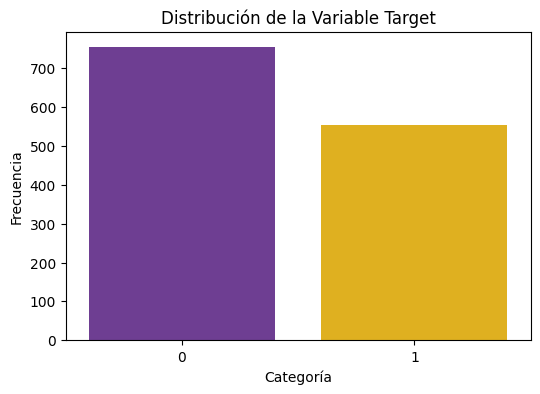

In [308]:
target="Survived"
pos_label=1

dataset_cleaned, target, pos_label = step_2_and_3(dataset=dataset_filtered,
                                                  variable_types=variable_types,
                                                  target=target,
                                                  pos_label=pos_label)


# Paso 4: Selección del modelo y del tamaño del conjunto de entrenamiento

Seleccionar modelo y tamaño del conjunto de entrenamiento

In [309]:
selected_model = 'Regresión Logística'
train_size = 0.7

select_model, train_size = step_4(target=target,
                                  variable_types=variable_types,
                                  selected_model=selected_model,
                                  train_size=train_size)

Paso 4: Selección del Modelo
Modelo confirmado: Regresión Logística
Tamaño del conjunto de entrenamiento: 0.70


# Paso 5: Selección de Variables Predictoras Fijas y Candidatas + Opción de Manejo de Valores Faltantes

Seleccionar las variables fijas y predictoras y seleccionar la opción de manejo de valores faltantes:
    
    - Opción 1: Eliminar filas con valores faltantes. (missing_data_handling = '1')
    
    - Opción 2: Imputación de valores faltantes (missing_data_handling = '2') (función no disponible)

In [310]:
# Obtener todas las variables predictoras disponibles
available_predictors = [col for col in dataset_cleaned.columns if col != target]

print("Variables predictoras disponibles:")
print(available_predictors)

Variables predictoras disponibles:
['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Embarked']


No debemos introducir al modelo variables identificadoras

In [311]:
fixed_predictors = []
candidate_predictors = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
missing_data_handling = '1'

fixed, candidates, train_dataset, missing_data_handling = step_5(dataset=dataset_cleaned,
                                                  target=target,
                                                  fixed_predictors=fixed_predictors,
                                                  candidate_predictors=candidate_predictors,
                                                  missing_data_handling=missing_data_handling)

Paso 5: Selección de Variables Predictoras
Cantidad de valores nulos por variable seleccionada:
Pclass        0
Sex           0
Age         263
SibSp         0
Parch         0
Fare          1
Embarked      2
dtype: int64
Los valores faltantes se tratarán mediante la eliminación de filas a la hora de entrenar el modelo con las variables que entren en el modelo.
Variables predictoras seleccionadas. En el modelo entrarán un total de máximo 10 predictoras.


# Paso 6: Entrenamiento del modelo

Entrenamos el modelo

In [312]:
trained_model, test_dataset, target_type, selected_features = step_6(train_dataset,
                                                             fixed,
                                                             candidates,
                                                             target, 
                                                             variable_types, 
                                                             train_size, 
                                                             missing_data_handling)

Paso 6: Entrenamiento del Modelo
Filas iniciales en el dataset: 1309
Filas después de aplicar get_dummies: 1309
✅ Se agrega la variable: Sex_male
✅ Se agrega la variable: Pclass
✅ Se agrega la variable: Age
✅ Se agrega la variable: SibSp

🔍 Variables finales seleccionadas: ['Sex_male', 'Pclass', 'Age', 'SibSp']
Filas después de la selección de variables: 1046
Filas en X_train: 732, Filas en X_test: 314
Variables seleccionadas: ['Sex_male', 'Pclass', 'Age', 'SibSp']
📊 Regresión Logística: 70% entrenamiento, 30% prueba.
✅ Modelo entrenado con éxito.


# Paso 7: Evaluación del Modelo

- Seleccionamos el threshold. Si no se selecciona ninguno específico, la función utilizará una función auxiliar la cual calculará el mejor umbral para maximizar el F1-Score.

- Seleccionamos el nivel de restricción de los intervalos de confianza de las métricas de evaluación:
    * **0.99**: MUY restrictivo
    * **0.95**: Restrictivo
    * **0.90**: POCO restrictivo

In [313]:
confidence = 0.95

Evaluamos el modelo

Paso 7: Evaluación del Modelo
Mejor threshold calculado: 0.47

📊 Evaluación del modelo de clasificación:

🔹 Evaluación con Threshold = 0.47

Matriz de Confusión:
        Predicción 0  Predicción 1
Real 0           129            56
Real 1            33            96
Accuracy: 0.72 [0.67, 0.76]
Precision: 0.63 [0.55, 0.71]
Recall (Sensibilidad): 0.74 [0.67, 0.82]
Especificidad: 0.70 [0.62, 0.76]
F1-Score: 0.68 [0.62, 0.74]
AUC: 0.78 [0.72, 0.83]
Log-Loss: 0.57


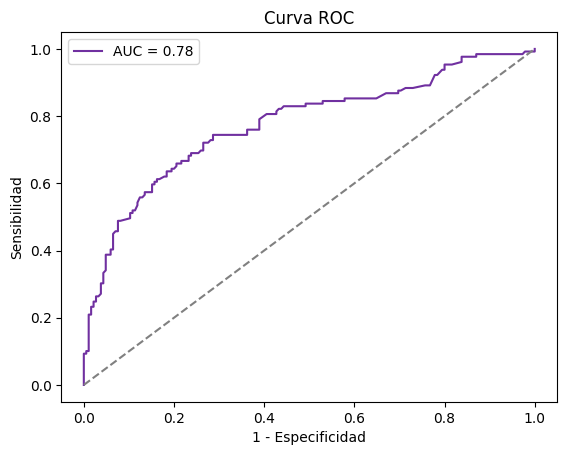

In [314]:
model_results, threshold_optimo = step_7(trained_model,
                      test_dataset,
                      target,
                      selected_features,
                      target_type,
                      confidence=confidence,
                      threshold=None)

# Paso 8: Creación de Subgrupos

Creamos subgrupos si queremos estudiar una población más específica dentro de nuestro modelo. Estos subgrupos se crean utilizando la misma estructura que en `filter_dataset`.

```python
filters = [(variable, tipo_filtro, valores)]
```

**Ejemplos**

1. Ejemplo con variable categórica (Queremos quedarnos con solamente los hombres)
```python
filters = [("Sex", "Categorías", ["male"])]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

2. Ejemplo con variable numérica (Queremos obtener las personas mayores de 30)
```python
filters = [("Age", "Mayor o igual", 30)]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

3. Ejemplo con dos variables (una categórica y una numérica) (Queremos obtener los hombres mayores de 30)
```python
filters = [("Sex", "Categorías", ["male"]), ("Age", "Mayor o igual", 35)]
dataset_filtered = filter_dataset(dataset, variable_types, filters)
```

In [315]:
# Añadir dos intervalos diferentes.
# subgroup = [('odd_d', 'Entre', (3.6, 3.9)), ('odd_d', 'Entre', (4.1, 5.4))]

Creamos una lista con todos los subgrupos que queremos evaluar.

In [316]:
subgroup1 = [("Sex", "Categorías", "male")]
subgroup2 = [("Sex", "Categorías", 'female')]
subgroup3 = [('Age', 'Mayor o igual', 30)]
subgroup4 = [('Age', 'Mayor o igual', 30), ("Sex", "Categorías", "male")]
subgroup5 = [('Age', 'Mayor o igual', 30), ("Sex", "Categorías", "female")]

list_of_subgroups = [subgroup1,
                     subgroup2, subgroup3,
                     subgroup4, subgroup5]

list_of_subgroups

[[('Sex', 'Categorías', 'male')],
 [('Sex', 'Categorías', 'female')],
 [('Age', 'Mayor o igual', 30)],
 [('Age', 'Mayor o igual', 30), ('Sex', 'Categorías', 'male')],
 [('Age', 'Mayor o igual', 30), ('Sex', 'Categorías', 'female')]]

Evaluamos el modelo para cada uno de los subgrupos seleccionados

Paso 8: Evaluación del Modelo en Subgrupos
Filtros aplicados:
Sex_male - Igual: True
El dataset ha pasado de tener 314 filas a 183 filas después de aplicar los filtros.

📊 Evaluación del modelo de clasificación:

🔹 Evaluación con Threshold = 0.47

Matriz de Confusión:
        Predicción 0  Predicción 1
Real 0           126            10
Real 1            32            15
Accuracy: 0.77 [0.70, 0.83]
Precision: 0.60 [0.38, 0.78]
Recall (Sensibilidad): 0.32 [0.18, 0.46]
Especificidad: 0.93 [0.88, 0.97]
F1-Score: 0.42 [0.25, 0.56]
AUC: 0.63 [0.53, 0.73]
Log-Loss: 0.56


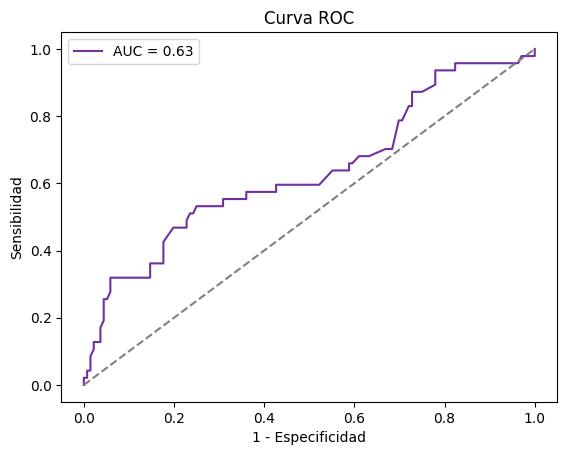

Paso 8: Evaluación del Modelo en Subgrupos
Filtros aplicados:
Sex_male - Igual: False
El dataset ha pasado de tener 314 filas a 131 filas después de aplicar los filtros.

📊 Evaluación del modelo de clasificación:

🔹 Evaluación con Threshold = 0.47

Matriz de Confusión:
        Predicción 0  Predicción 1
Real 0             3            46
Real 1             1            81
Accuracy: 0.64 [0.56, 0.73]
Precision: 0.64 [0.55, 0.73]
Recall (Sensibilidad): 0.99 [0.96, 1.00]
Especificidad: 0.06 [0.00, 0.14]
F1-Score: 0.78 [0.71, 0.84]
AUC: 0.78 [0.70, 0.86]
Log-Loss: 0.58


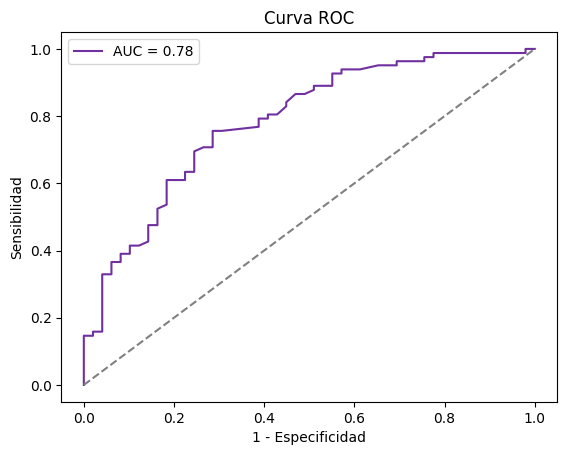

Paso 8: Evaluación del Modelo en Subgrupos
Filtros aplicados:
Age - Mayor o igual: 30
El dataset ha pasado de tener 314 filas a 139 filas después de aplicar los filtros.

📊 Evaluación del modelo de clasificación:

🔹 Evaluación con Threshold = 0.47

Matriz de Confusión:
        Predicción 0  Predicción 1
Real 0            65            22
Real 1             9            43
Accuracy: 0.78 [0.71, 0.84]
Precision: 0.66 [0.54, 0.77]
Recall (Sensibilidad): 0.83 [0.72, 0.92]
Especificidad: 0.75 [0.66, 0.83]
F1-Score: 0.74 [0.64, 0.82]
AUC: 0.86 [0.79, 0.92]
Log-Loss: 0.50


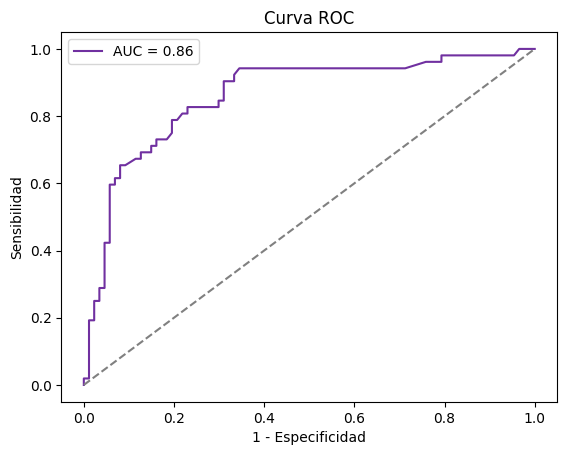

Paso 8: Evaluación del Modelo en Subgrupos
Filtros aplicados:
Age - Mayor o igual: 30
Sex_male - Igual: True
El dataset ha pasado de tener 314 filas a 82 filas después de aplicar los filtros.

📊 Evaluación del modelo de clasificación:

🔹 Evaluación con Threshold = 0.47

Matriz de Confusión:
        Predicción 0  Predicción 1
Real 0            63             4
Real 1             8             7
Accuracy: 0.85 [0.77, 0.93]
Precision: 0.64 [0.30, 0.90]
Recall (Sensibilidad): 0.47 [0.20, 0.75]
Especificidad: 0.94 [0.88, 0.99]
F1-Score: 0.54 [0.25, 0.75]
AUC: 0.79 [0.61, 0.94]
Log-Loss: 0.46


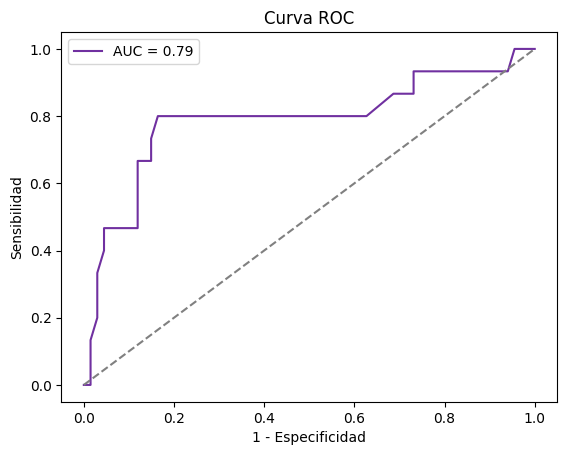

Paso 8: Evaluación del Modelo en Subgrupos
Filtros aplicados:
Age - Mayor o igual: 30
Sex_male - Igual: False
El dataset ha pasado de tener 314 filas a 57 filas después de aplicar los filtros.

📊 Evaluación del modelo de clasificación:

🔹 Evaluación con Threshold = 0.47

Matriz de Confusión:
        Predicción 0  Predicción 1
Real 0             2            18
Real 1             1            36
Accuracy: 0.67 [0.53, 0.79]
Precision: 0.67 [0.54, 0.78]
Recall (Sensibilidad): 0.97 [0.91, 1.00]
Especificidad: 0.10 [0.00, 0.26]
F1-Score: 0.79 [0.69, 0.87]
AUC: 0.79 [0.65, 0.92]
Log-Loss: 0.55


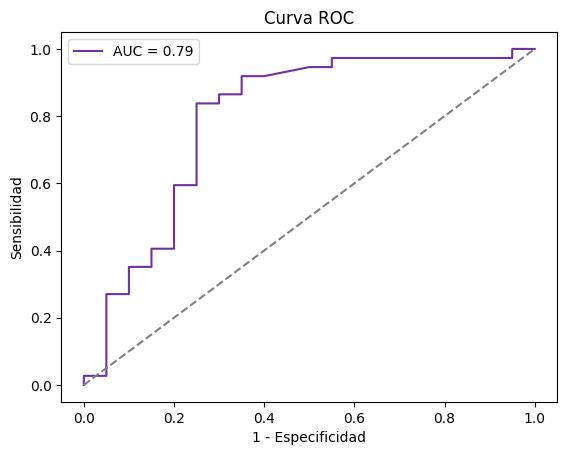

In [317]:
subgroups_results = {}

for subgroup_filters in list_of_subgroups:  
    subgroup_parts = []

    for variable, filter_type, values in subgroup_filters:
        # Convertimos `values` a string, manejando correctamente listas, tuplas y otros tipos
        if isinstance(values, (list, tuple)):
            if filter_type == "Entre":
                values_str = f"({values[0]},{values[1]})"  # Formato para rango
            else:
                values_str = "_".join(map(str, values))  # Convierte listas y tuplas a un string separado por "_"
        else:
            values_str = str(values)  # Convierte números o strings directamente

        # Determinar el formato según filter_type
        if filter_type == "Categorías":
            subgroup_parts.append(f"{variable}_{values_str}")  # Sin prefijo
        elif filter_type == "Mayor o igual":
            subgroup_parts.append(f"{variable}>={values_str}")
        elif filter_type == "Menor o igual":
            subgroup_parts.append(f"{variable}<={values_str}")
        elif filter_type == "Mayor":
            subgroup_parts.append(f"{variable}>{values_str}")
        elif filter_type == "Menor":
            subgroup_parts.append(f"{variable}<{values_str}")
        elif filter_type == "Igual":
            subgroup_parts.append(f"{variable}={values_str}")
        elif filter_type == "Entre":
            subgroup_parts.append(f"{variable}{values_str}")

    # Unimos todas las partes con `_and_` en caso de múltiples condiciones
    subgroup_name = "_and_".join(subgroup_parts)

    subgroups_results[subgroup_name] = step_8(
        test_dataset, trained_model, target, variable_types, subgroup_filters, dict_variables, confidence, threshold_optimo
    )


# Forest Plot Comparativa General y Subgrupos Generados

Combino los resultados del modelo principal con los resultados de los subgrupos en un mismo diccionario

In [318]:
combined_results = combine_results_for_forest_plot(model_results, subgroups_results)

Selecciono la métrica que quiero comparar de entre las siguientes:

- Accuracy
- Precision
- Recall
- Specificity
- F1
- AUC

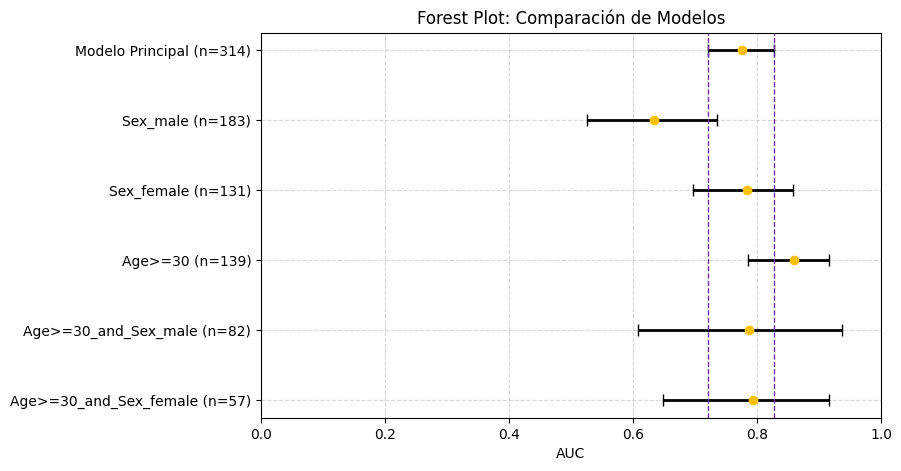

In [319]:
forest_plot(combined_results, metric_name="AUC")